<a href="https://colab.research.google.com/github/dean-sh/Movie-Ratings-Collaborating-Filltering/blob/master/Embeddings%20(Fast%20AI%2C%20Keras).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MovieLens Recommendations - Embeddings
=============================================
## Dean Shabi, Dedi Kovatch, July 2019
## Final Project for TCDS - Technion Data Science Specialization

MovieLens data sets were collected by the GroupLens Research Project
at the University of Minnesota.
 
This data set consists of:
	* 100,000 ratings (1-5) from 943 users on 1682 movies. 
	* Each user has rated at least 20 movies. 
        * Simple demographic info for the users (age, gender, occupation, zip)

The data was collected through the MovieLens web site
(movielens.umn.edu) during the seven-month period from September 19th, 
1997 through April 22nd, 1998. This data has been cleaned up - users
who had less than 20 ratings or did not have complete demographic
information were removed from this data set. Detailed descriptions of
the data file can be found at the end of this file.


## Data Description




Here are brief descriptions of the data.

ml-data.tar.gz   -- Compressed tar file.  To rebuild the u data files do this:
                gunzip ml-data.tar.gz
                tar xvf ml-data.tar
                mku.sh

u.data     -- The full u data set, 100000 ratings by 943 users on 1682 items.
              Each user has rated at least 20 movies.  Users and items are
              numbered consecutively from 1.  The data is randomly
              ordered. This is a tab separated list of 
	         user id | item id | rating | timestamp. 
              The time stamps are unix seconds since 1/1/1970 UTC   

u.info     -- The number of users, items, and ratings in the u data set.

u.item     -- Information about the items (movies); this is a tab separated
              list of
              movie id | movie title | release date | video release date |
              IMDb URL | unknown | Action | Adventure | Animation |
              Children's | Comedy | Crime | Documentary | Drama | Fantasy |
              Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
              Thriller | War | Western |
              The last 19 fields are the genres, a 1 indicates the movie
              is of that genre, a 0 indicates it is not; movies can be in
              several genres at once.
              The movie ids are the ones used in the u.data data set.

u.genre    -- A list of the genres.

u.user     -- Demographic information about the users; this is a tab
              separated list of
              user id | age | gender | occupation | zip code
              The user ids are the ones used in the u.data data set.

u.occupation -- A list of the occupations.

u1.base    -- The data sets u1.base and u1.test through u5.base and u5.test
u1.test       are 80%/20% splits of the u data into training and test data.
u2.base       Each of u1, ..., u5 have disjoint test sets; this if for
u2.test       5 fold cross validation (where you repeat your experiment
u3.base       with each training and test set and average the results).
u3.test       These data sets can be generated from u.data by mku.sh.
u4.base
u4.test
u5.base
u5.test

ua.base    -- The data sets ua.base, ua.test, ub.base, and ub.test
ua.test       split the u data into a training set and a test set with
ub.base       exactly 10 ratings per user in the test set.  The sets
ub.test       ua.test and ub.test are disjoint.  These data sets can
              be generated from u.data by mku.sh.

allbut.pl  -- The script that generates training and test sets where
              all but n of a users ratings are in the training data.

mku.sh     -- A shell script to generate all the u data sets from u.data.

## Imports




In [0]:
import numpy as np
import pandas as pd
import collections
import seaborn as sns
%matplotlib inline
# from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
# import tensorflow as tf
# tf.logging.set_verbosity(tf.logging.ERROR)

# # Add some convenience functions to Pandas DataFrame.
# pd.options.display.max_rows = 10
# pd.options.display.float_format = '{:.3f}'.format



# # Install Altair and activate its colab renderer.
# print("Installing Altair...")
# !pip install git+git://github.com/altair-viz/altair.git
# import altair as alt
# alt.data_transformers.enable('default', max_rows=None)
# alt.renderers.enable('colab')
# print("Done installing Altair.")

# # Install spreadsheets and import authentication module.
# USER_RATINGS = False
# !pip install --upgrade -q gspread
# from google.colab import auth
# import gspread
# from oauth2client.client import GoogleCredentials

## **Importing dataset, preprocessing**




In [0]:
# download the MovieLens Data, and create DataFrames containing movies, users, and ratings.

print("Downloading movielens data...")
import zipfile
import urllib.request

urllib.request.urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info'))

In [0]:
# Load each data set (users, movies, and ratings).
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(
    'ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    'ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

# The movies file contains a binary feature for each genre.
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"] + genre_cols

movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')


Some Preproccessing

In [0]:
# Since the ids start at 1, we shift them to start at 0.
users["user_id"] = users["user_id"].apply(lambda x: str(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: str(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: str(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: str(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

# Compute the number of movies to which a genre is assigned.
genre_occurences = movies[genre_cols].sum().to_dict()

# Since some movies can belong to more than one genre, we create different
# 'genre' columns as follows:
# - all_genres: all the active genres of the movie.
# - genre: randomly sampled from the active genres.
def mark_genres(movies, genres):
    def get_random_genre(gs):
        active = [genre for genre, g in zip(genres, gs) if g==1]
        if len(active) == 0:
            return 'Other'
        return np.random.choice(active)
    def get_all_genres(gs):
        active = [genre for genre, g in zip(genres, gs) if g==1]
        if len(active) == 0:
            return 'Other'
        return '-'.join(active)
    movies['genre'] = [
        get_random_genre(gs) for gs in zip(*[movies[genre] for genre in genres])]
    movies['all_genres'] = [
        get_all_genres(gs) for gs in zip(*[movies[genre] for genre in genres])]

mark_genres(movies, genre_cols)

In [0]:
# Create one merged DataFrame containing all the movielens data.
movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')

# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
    """Splits a DataFrame into training and test sets.
    Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
    Returns:
    train: dataframe for training
    test: dataframe for testing
    """
    test = df.sample(frac=holdout_fraction, replace=False)
    train = df[~df.index.isin(test.index)]
    return train, test

In [0]:
movies.head()

,movie_id,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,genre,all_genres
0,0,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1995,Comedy,Animation-Children-Comedy
1,1,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1995,Adventure,Action-Adventure-Thriller
2,2,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1995,Thriller,Thriller
3,3,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1995,Comedy,Action-Comedy-Drama
4,4,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1995,Crime,Crime-Drama-Thriller


In [0]:
users.head()

,user_id,age,sex,occupation,zip_code
0,0,24,M,technician,85711
1,1,53,F,other,94043
2,2,23,M,writer,32067
3,3,24,M,technician,43537
4,4,33,F,other,15213


In [0]:
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,195,241,3.0,881250949
1,185,301,3.0,891717742
2,21,376,1.0,878887116
3,243,50,2.0,880606923
4,165,345,1.0,886397596


In [0]:
movielens.head()

,user_id,movie_id,rating,unix_timestamp,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,genre,all_genres,age,sex,occupation,zip_code
0,195,241,3.0,881250949,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1997,Comedy,Comedy,49,M,writer,55105
1,195,256,2.0,881251577,Men in Black (1997),04-Jul-1997,NaN,http://us.imdb.com/M/title-exact?Men+in+Black+...,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1997,Sci-Fi,Action-Adventure-Comedy-Sci-Fi,49,M,writer,55105
2,195,110,4.0,881251793,"Truth About Cats & Dogs, The (1996)",26-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Truth%20About...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1996,Comedy,Comedy-Romance,49,M,writer,55105
3,195,24,4.0,881251955,"Birdcage, The (1996)",08-Mar-1996,NaN,"http://us.imdb.com/M/title-exact?Birdcage,%20T...",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1996,Comedy,Comedy,49,M,writer,55105
4,195,381,4.0,881251843,"Adventures of Priscilla, Queen of the Desert, ...",01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Adventures%20...,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1994,Comedy,Comedy-Drama,49,M,writer,55105


# FastAI Embeddings model

In [0]:
# !pip install fastai
import pandas as pd
from fastai.collab import CollabDataBunch, collab_learner, EmbeddingNN


In [0]:
data = CollabDataBunch.from_df(ratings, valid_pct=0.15)
data.show_batch()



## EmbeddingDotBias Model

In [0]:
learn = collab_learner(data, n_factors=50, y_range=(0.,5.), wd=.1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


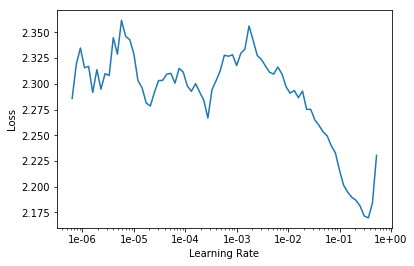

In [0]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [0]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.963994,0.956801,00:08
1,0.868230,0.883104,00:08
2,0.793230,0.830477,00:08
3,0.669829,0.811959,00:09
4,0.576130,0.809654,00:08


In [0]:
(users, items), ratings = next(iter(data.valid_dl))
preds = learn.model(users, items)
print('Real\tPred\tDifference')
for p in list(zip(ratings, preds))[:16]:
    print('{}\t{:.1f}\t{:.1f}'.format(p[0],p[1],p[1]-p[0]))


Real	Pred	Difference
3.0	2.2	-0.8
4.0	2.9	-1.1
2.0	2.8	0.8
3.0	2.9	-0.1
5.0	4.3	-0.7
3.0	3.7	0.7
1.0	2.4	1.4
5.0	4.3	-0.7
4.0	3.4	-0.6
1.0	2.9	1.9
4.0	4.2	0.2
5.0	4.3	-0.7
5.0	3.7	-1.3
2.0	2.9	0.9
2.0	3.1	1.1
2.0	3.7	1.7


##EmbeddingNN  Model

In [0]:
learn = collab_learner(data, use_nn=True, emb_szs={'user_id': 40, 'movie_id':40}, layers=[256, 128], y_range=(1, 5))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


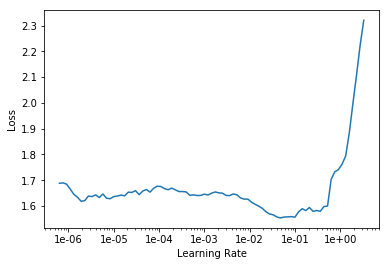

In [0]:
learn.lr_find() # find learning rate
learn.recorder.plot() # plot learning rate graph


In [0]:
learn.fit_one_cycle(5, 1e-2)


epoch,train_loss,valid_loss,time
0,0.996246,0.963006,00:11
1,0.914653,0.900042,00:11
2,0.883064,0.878848,00:11
3,0.818831,0.861804,00:11
4,0.784336,0.864615,00:11


In [0]:
learn.save('movies-dot-1')


# Recommendation using Keras Embeddings

We used a NN based Matrix Factorization method, where the matrices are embeddings learned my the model.
The final layer is a dot product as usual in MF.



In [0]:
# Load each data set (users, movies, and ratings).
ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']

train_df = pd.read_csv(
    'ml-100k/u1.base', sep='\t', names=ratings_cols, encoding='latin-1')

test_df = pd.read_csv(
    'ml-100k/u1.test', sep='\t', names=ratings_cols, encoding='latin-1')

In [0]:
pivot_train = train_df.pivot_table(values = 'rating', index = 'movie_id', columns = 'user_id')
pivot_train.fillna(0, inplace = True)

pivot_test = test_df.pivot_table(values = 'rating', index = 'movie_id', columns = 'user_id')
pivot_test.fillna(0, inplace = True)

In [0]:
# https://nipunbatra.github.io/blog/2017/recommend-keras.html

In [0]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(train_df[['user_id','movie_id','rating']], test_size=0.2)

In [0]:
train.shape, test.shape

((64000, 3), (16000, 3))

In [0]:
#Matrix factorisation in Keras
import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
n_users, n_movies = len(movielens.user_id.unique()), len(movielens.movie_id.unique())
from keras.regularizers import l2, l1

n_latent_factors = 30

Using TensorFlow backend.


**Dot architecture - Multi layer Embeddings**

Dedi - I added L1 regularization, because we were overfitting pretty hard.
L1 instead of L2, because L2 tends to make weights go to 0, and we will use the meaning of the embedding that way.

In [0]:
movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='Movie-Embedding', 
                                         embeddings_regularizer=l1(1e-6))(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1,
                                                                            n_latent_factors,name='User-Embedding',
                                                                           embeddings_regularizer=l1(1e-6))(user_input))

prod = keras.layers.dot([movie_vec, user_vec], axes=1, normalize=False) #original command from article: prod = keras.layers.merge([movie_vec, user_vec], mode='dot',name='DotProduct')
model = keras.Model([user_input, movie_input], prod)
model.compile(keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0001, amsgrad=False), 'mae', metrics=['mse'])

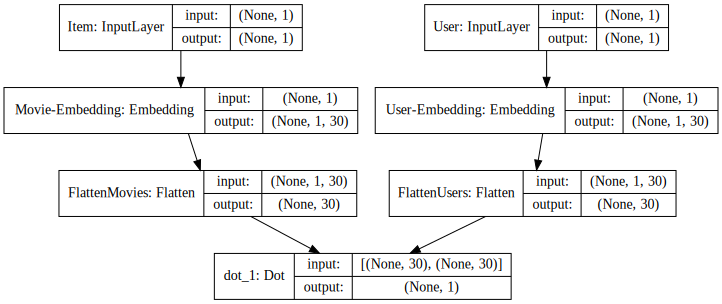

In [0]:
#model visualization
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [0]:
    model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 30)        50490       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 30)        28320       User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

 **TODO** 


1.   Add CV instead of test-train split
2.   Try different hyperparameters



In [0]:
history = model.fit([train.user_id, train.movie_id], train.rating, epochs=80, batch_size = 128,
                    validation_split=0.2, verbose=1)

Train on 51200 samples, validate on 12800 samples
Epoch 1/80
51200/51200 [==============================] - 2s 31us/step - loss: 3.4865 - mean_squared_error: 13.3849 - val_loss: 3.2157 - val_mean_squared_error: 11.5401
Epoch 2/80
51200/51200 [==============================] - 1s 26us/step - loss: 2.1190 - mean_squared_error: 6.0186 - val_loss: 1.2726 - val_mean_squared_error: 2.4976
Epoch 3/80
51200/51200 [==============================] - 1s 26us/step - loss: 1.0456 - mean_squared_error: 1.7498 - val_loss: 0.9500 - val_mean_squared_error: 1.4418
Epoch 4/80
51200/51200 [==============================] - 1s 26us/step - loss: 0.8648 - mean_squared_error: 1.2080 - val_loss: 0.8637 - val_mean_squared_error: 1.1889
Epoch 5/80
51200/51200 [==============================] - 1s 26us/step - loss: 0.8056 - mean_squared_error: 1.0466 - val_loss: 0.8262 - val_mean_squared_error: 1.0878
Epoch 6/80
51200/51200 [==============================] - 1s 26us/step - loss: 0.7784 - mean_squared_error: 0.976

KeyboardInterrupt: ignored

**With Regularization:**

In [0]:
#train loss vs. epochs 
pd.Series(history.history['loss']).plot(logy=True, label = "Train Loss")
pd.Series(history.history['val_loss']).plot(logy=True, color='green', label = "Val Loss")

plt.title("Train Loss vs Val Loss - with L1 regularization")
plt.xlabel("Epoch")
plt.ylabel("Loss (Log)")
plt.legend()

y_hat = np.round(model.predict([test.user_id, test.movie_id]),0)
y_true = test.rating

from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_hat)


**Without Regularization:**

This is a clear overfit :)


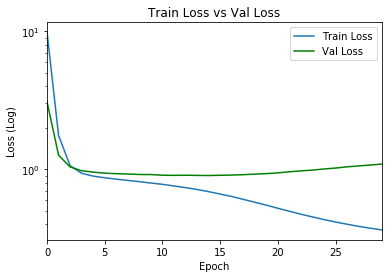

In [0]:
#train loss vs. epochs 
pd.Series(history.history['loss']).plot(logy=True, label = "Train Loss")
pd.Series(history.history['val_loss']).plot(logy=True, color='green', label = "Val Loss")

plt.title("Train Loss vs Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (Log)")
plt.legend()

print("This is a clear overfit :) \n")

In [0]:
y_hat = np.round(model.predict([test.user_id, test.movie_id]),0)
y_true = test.rating

from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_hat)


0.7715

**Embeddings->NN Architecture**

In [0]:
n_latent_factors_user = 5
n_latent_factors_movie = 8

movie_input = keras.layers.Input(shape=[1],name='Movie')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
movie_vec = keras.layers.Dropout(0.012)(movie_vec)


user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,
                                                                            name='User-Embedding')(user_input))
user_vec = keras.layers.Dropout(0.02)(user_vec)


concat = keras.layers.concatenate([movie_vec, user_vec], axis= 1, name='Concat')


concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(200,name='FullyConnected')(concat)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
dense_2 = keras.layers.Dense(100,name='FullyConnected-1')(concat)
dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)
dense_3 = keras.layers.Dense(50,name='FullyConnected-2')(dense_2)
dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)
dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dense_3)


result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
adam = Adam()
model = keras.Model([user_input, movie_input], result)
model.compile(optimizer=adam,loss= 'mean_squared_error')

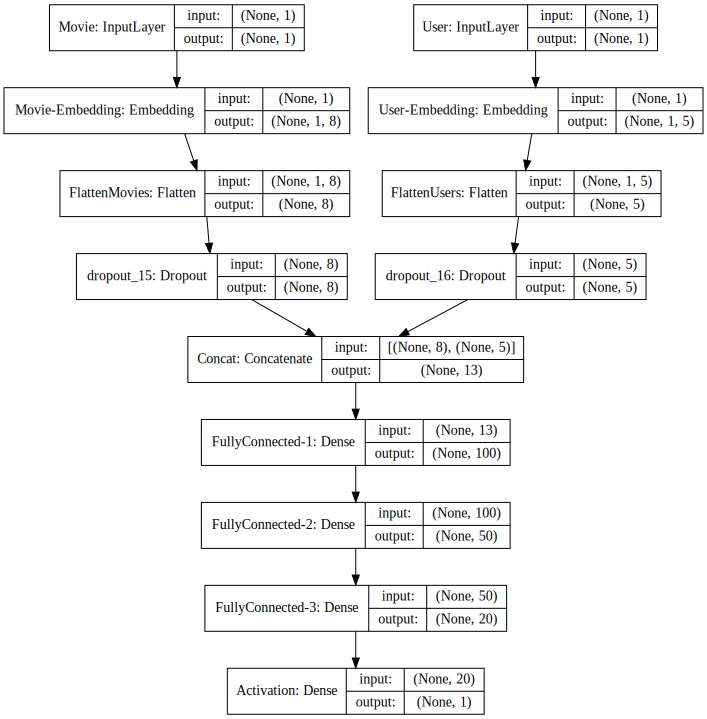

In [0]:
#model visualization
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [0]:
history = model.fit([train.user_id, train.movie_id], train.rating, epochs=50, 
                    validation_split=0.2, verbose=1)

Train on 64000 samples, validate on 16000 samples
Epoch 1/50
64000/64000 [==============================] - 10s 152us/step - loss: 1.1961 - val_loss: 0.9325
Epoch 2/50
64000/64000 [==============================] - 9s 133us/step - loss: 0.8980 - val_loss: 0.9178
Epoch 3/50
64000/64000 [==============================] - 9s 133us/step - loss: 0.8873 - val_loss: 0.9195
Epoch 4/50
64000/64000 [==============================] - 8s 133us/step - loss: 0.8769 - val_loss: 0.9051
Epoch 5/50
64000/64000 [==============================] - 9s 133us/step - loss: 0.8739 - val_loss: 0.9064
Epoch 6/50
64000/64000 [==============================] - 9s 134us/step - loss: 0.8700 - val_loss: 0.9048
Epoch 7/50
64000/64000 [==============================] - 9s 134us/step - loss: 0.8658 - val_loss: 0.9081
Epoch 8/50
64000/64000 [==============================] - 8s 133us/step - loss: 0.8572 - val_loss: 0.8882
Epoch 9/50
64000/64000 [==============================] - 9s 134us/step - loss: 0.8413 - val_loss: 0.

0.7235

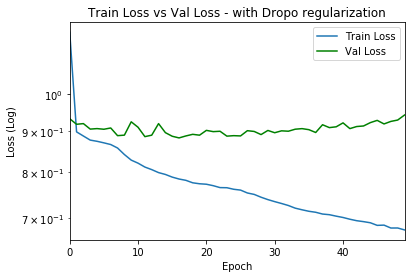

In [0]:
#train loss vs. epochs 
pd.Series(history.history['loss']).plot(logy=True, label = "Train Loss")
pd.Series(history.history['val_loss']).plot(logy=True, color='green', label = "Val Loss")

plt.title("Train Loss vs Val Loss - with Dropo regularization")
plt.xlabel("Epoch")
plt.ylabel("Loss (Log)")
plt.legend()

y_hat = np.round(model.predict([test.user_id, test.movie_id]),0)
y_true = test.rating

from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_hat)


In [0]:
#Matedata Exploration

# users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
userinfo = pd.read_csv(
    'ml-100k/u.info', sep='', names=users_cols, encoding='latin-1')
userinfo


,user_id,age,sex,occupation,zip_code
0,943 users,NaN,NaN,NaN,NaN
1,1682 items,NaN,NaN,NaN,NaN
2,100000 ratings,NaN,NaN,NaN,NaN


In [0]:
# Reading ratings file
ratings = pd.read_csv('ratings.csv', sep='\t', encoding='latin-1', 
                      usecols=['user_id', 'movie_id', 'user_emb_id', 'movie_emb_id', 'rating'])
max_userid = ratings['user_id'].drop_duplicates().max()
max_movieid = ratings['movie_id'].drop_duplicates().max()

# Reading ratings file
users = pd.read_csv('users.csv', sep='\t', encoding='latin-1', 
                    usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])

# Reading ratings file
movies = pd.read_csv('movies.csv', sep='\t', encoding='latin-1', 
                     usecols=['movie_id', 'title', 'genres'])


FileNotFoundError: ignored

In [0]:
.# Create training set
shuffled_ratings = ratings.sample(frac=1., random_state=42)

# Shuffling users
Users = shuffled_ratings['user_emb_id'].values
print ('Users:', Users, ', shape =', Users.shape)

# Shuffling movies
Movies = shuffled_ratings['movie_emb_id'].values
print ('Movies:', Movies, ', shape =', Movies.shape)

# Shuffling ratings
Ratings = shuffled_ratings['rating'].values
print ('Ratings:', Ratings, ', shape =', Ratings.shape)


KeyError: ignored